# Chap 6 Linear Model Selection and Regularization

## Lab1 Hitters dataset

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import combinations

from sklearn.linear_model import *
from sklearn.preprocessing import *
from sklearn.feature_selection import *
from sklearn.metrics import *
from sklearn.model_selection import *

In [44]:
hitters = pd.read_csv('../data/Hitters.csv').dropna()
assert hitters.isna().sum().sum() == 0
hitters.index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            311, 312, 313, 314, 315, 317, 318, 319, 320, 321],
           dtype='int64', length=263)

In [45]:
# Create dummy variables for qualitative features
qual = ['League', 'Division', 'NewLeague']
hitters = pd.get_dummies(hitters,columns= qual)
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,0,1,0,1,0,1
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480.0,1,0,0,1,1,0
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500.0,0,1,1,0,0,1
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91.5,0,1,1,0,0,1
5,594,169,4,74,51,35,11,4408,1133,19,...,282,421,25,750.0,1,0,0,1,1,0


## Lab 1: Subset Selection Methods

## 6.5.1 Best subset selection

Perform best subset selection by identifying the best model that contains a given number of predictors, where best is quantified using RSS.

In [46]:
def get_models(k, X, y):
    X_combos = combinations(list(X.columns), k)
    
    models = []
    for X_label in X_combos:
        X_smf = ' + '.join(X_label)
        f     = 'Salary ~ {}'.format(X_smf)
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        models += [(f, model)]
    return models

def min_rss(statsmodels):
    return sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]

def min_bic(statsmodels):
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].bic)[0]

def max_adjr2(statsmodels):
    return sorted(statsmodels, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]


### Which model with 2 predictors yields lowest RSS score?

In [47]:
X = hitters.drop('Salary', axis=1)
y = hitters['Salary']

k = 2
subset = get_models(k, X, y)

print(f'This model yields the lowest RSS score for the subset of models with {format(k)} predictors:')
display(min_rss(subset))

print(f'This model yields the highest adjusted R-squared score for the subset of models with {format(k)} predictors:')
max_adjr2(get_models(2, X, y))

This model yields the lowest RSS score for the subset of models with 2 predictors:


('Salary ~ Hits + CRBI',
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x144135b80>)

This model yields the highest adjusted R-squared score for the subset of models with 2 predictors:


('Salary ~ Hits + CRBI',
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x183d6efd0>)

In [48]:
X.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors', 'League_A', 'League_N', 'Division_E', 'Division_W',
       'NewLeague_A', 'NewLeague_N'],
      dtype='object')

How do the the maximum $R^2$, minimum RSS, and BIC statistics vary for each subset with k predictors? 

First we fit all possible models in each subset of models with k predictors. This turns out to be a very computationally expensive process, running on my laptop for 30 minutes yielded results up to only k=6 and occupied 30GB of memeory. Not suprising as number of possible combinations without repetition is given by:

$$\frac{p!}{k!(p-k)!}$$

Where *p* is number of predictors to choose from and we choose *k* of them.

In this example p=22, there are 22 predictors.

For k = 4 the number of possible combinations is given by:

$$\frac{22!}{4!x 18!} = 74,613$$


[Text(0.5, 0, 'k'), Text(0, 0.5, 'combinations')]

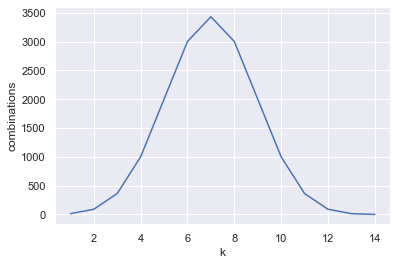

In [49]:
from scipy.special import factorial

n =14
k = np.arange(1, n+1)
y = factorial(n)/(factorial(k) * factorial(n-k))

ax = sns.lineplot(x=k,y=y)
ax.set(xlabel='k', ylabel='combinations')

The plot above shows that there up to ~700,000 possible combinations of the predictors without repetition for some values of k when p = 22

The ISL authors provide comparison of the $R^2$ statistic for all combinations of 19 predictors. When p=19 the max number of combinations for any given subset is reduced by 10x, when p=10 the max combinations is reduced by ~2000x. 

My current machine maxed out its memory trying to compute all models for p=22. I'll try p=14 by picking 14 of the predictors for brevity. 



In [50]:
# Pick arbitrary subset of predictors to save compute/memory
X= hitters.loc[:, 'AtBat':'PutOuts']
y= hitters['Salary']

model_subsets = []
for k in range(1,7):
    subset = get_models(k,X,y)
    model_subsets += [subset]
    print(f'Progress : k = {format(k)}, done,')

# Try it but it works slowly.

Progress : k = 1, done,
Progress : k = 2, done,
Progress : k = 3, done,
Progress : k = 4, done,
Progress : k = 5, done,
Progress : k = 6, done,


Text(0.5, 1.0, 'BIC')

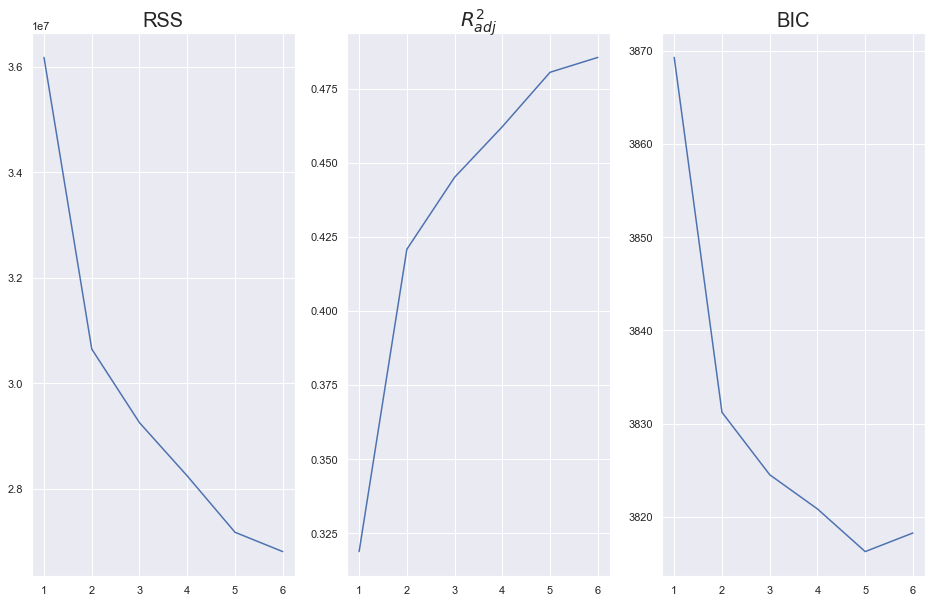

In [51]:
rss   = [min_rss(m)[1].ssr for m in model_subsets]
bic = [min_bic(m)[1].bic for m in model_subsets]
adjr2 = [max_adjr2(m)[1].rsquared_adj for m in model_subsets]

k     = np.arange(1, len(rss)+1)

_, axes = plt.subplots(1,3,figsize=[16,10])


sns.lineplot(x=k, y=rss,ax = axes[0])
sns.lineplot(x=k, y=adjr2,ax = axes[1])
sns.lineplot(x=k, y=bic,ax = axes[2])
axes[0].set_title('RSS',fontsize=20)
axes[1].set_title('$R_{adj}^2$',fontsize=20)
axes[2].set_title('BIC',fontsize=20)

The stats above seem to confer that a model with around 8 predictors is best. But has each method chosen the same or similar models

In [52]:
best_subset_6 = list(min_rss(model_subsets[5])[1].params.index)[1:]
print(best_subset_6)

['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts']


In [53]:
list(max_adjr2(model_subsets[5])[1].params.index)[1:]

['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts']

In [54]:
list(min_bic(model_subsets[5])[1].params.index)[1:]

['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts']

All three statisticis yield the same model for the subset with 6 predictors. This is expected for RSS and R-squared stats because they are related.

### 6.5.2 Forward and Backward Stepwise Selection

In [55]:
def forward_stepwise(X, y, results=[(0, [])]):
    # List predictors that havent's been used so far
    p_all    = list(X.columns)
    p_used   = results[-1][1]
    p_unused = [p for p in p_all if p not in p_used]
    
    # Job done, exit recursion
    if not p_unused:
        rss   = [r[0] for r in results]
        preds = [r[1] for r in results]
        return pd.DataFrame({'rss': rss, 'predictors': preds}).drop(0).reset_index()
    
    # Get rss score for each possible additional predictor
    r = []
    for p in p_unused:
        f     = 'Salary ~ {}'.format('+'.join([p]+p_used))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r     += [(model.ssr, [p]+p_used)]
    
    # Choose predictor which yields lowest rss
    min_rss     = sorted(r, key=lambda tup: tup[0])[0]   
    new_results = results + [min_rss]
    # Recursive call to self
    return forward_stepwise(X, y, new_results)

In [56]:
def backward_stepwise(X, y, results=[]):
    # List predictors that havent's been used so far
    p_all    = list(X.columns)

    # Check if we're starting out here
    if not results:
        # Fit model with all features
        f     = 'Salary ~ {}'.format('+'.join(p_all))
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Begin backward stepwise recursion
        return backward_stepwise(X, y, [(model.ssr, p_all)])
    else:
        p_used = results[-1][1]
    
    # Job done, exit recursion
    if len(p_used) == 1:
        rss   = [r[0] for r in results]
        preds = [r[1] for r in results]
        return pd.DataFrame({'rss': rss, 'predictors': preds})    
    
    # Get rss score for each possible removed predictor
    r = []
    for p in p_used:
        p_test = [i for i in p_used if i != p]
        f     = 'Salary ~ {}'.format('+'.join(p_test))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r     += [(model.ssr, p_test)]
    
    min_rss     = sorted(r, key=lambda tup: tup[0])[0]   
    new_results = results + [min_rss]
    return backward_stepwise(X, y, new_results)

In [57]:
scaler = StandardScaler()
X = scaler.fit_transform(hitters.loc[:, 'AtBat':'PutOuts'])
X_new = pd.DataFrame(X)
X_new.columns = hitters.loc[:, 'AtBat':'PutOuts'].columns
y = hitters['Salary']

forward_stepwise  = forward_stepwise(X_new, y)
print(forward_stepwise)
print('-'*30)
backward_stepwise = backward_stepwise(X_new, y)
print(backward_stepwise)

    index           rss                                         predictors
0       1  4.542829e+07                                          [PutOuts]
1       2  4.532160e+07                                   [Years, PutOuts]
2       3  4.522233e+07                             [CRBI, Years, PutOuts]
3       4  4.501844e+07                      [CRuns, CRBI, Years, PutOuts]
4       5  4.485676e+07              [CAtBat, CRuns, CRBI, Years, PutOuts]
5       6  4.477311e+07       [CHits, CAtBat, CRuns, CRBI, Years, PutOuts]
6       7  4.470303e+07  [AtBat, CHits, CAtBat, CRuns, CRBI, Years, Put...
7       8  4.426874e+07  [Runs, AtBat, CHits, CAtBat, CRuns, CRBI, Year...
8       9  4.416942e+07  [Walks, Runs, AtBat, CHits, CAtBat, CRuns, CRB...
9      10  4.411388e+07  [RBI, Walks, Runs, AtBat, CHits, CAtBat, CRuns...
10     11  4.409301e+07  [CHmRun, RBI, Walks, Runs, AtBat, CHits, CAtBa...
11     12  4.404634e+07  [HmRun, CHmRun, RBI, Walks, Runs, AtBat, CHits...
12     13  4.403416e+07  

In [58]:
print('Best Subset Selection       : {}'.format(sorted(best_subset_6)))
print('Forward Stepwise Selection  : {}'.format(sorted(forward_stepwise.loc[5]['predictors'])))
print('Backward Stepwise Selection : {}'.format(sorted(backward_stepwise.loc[8]['predictors'])))

Best Subset Selection       : ['AtBat', 'CRuns', 'CWalks', 'Hits', 'PutOuts', 'Walks']
Forward Stepwise Selection  : ['CAtBat', 'CHits', 'CRBI', 'CRuns', 'PutOuts', 'Years']
Backward Stepwise Selection : ['AtBat', 'CAtBat', 'CHits', 'CWalks', 'Runs', 'Years']


The above results show that Backward Stepwise Selection chooses the same 6 predictors as Best Subset Selection. Forward Stepwise Selection chooses all but one of the same predictors.

Backward Stepwise Selection therefore looks like the best approach as it makes the same optimal selection as best subset selection, but with significantly lower computational cost.

### 6.5.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation

In [59]:
def best_subset_rss(X, y):
    model_subsets = []
    for k in range(len(X.columns)):
        k=k+1
        subset = get_models(k, X, y)
        model_subsets += [subset]
        print('Best subset selected: k = {}/{}, done'.format(k, len(X.columns)))
    # Get best rss score for each subset
    return [min_rss(m) for m in model_subsets]

def mse(y_hat, y):
    return np.sum(np.square(y_hat - y)) / y.size

In [60]:
np.random.seed(1)
train = np.random.rand(len(hitters)) < 0.5

response = 'Salary'

X_train = hitters[train].loc[:, 'AtBat':'PutOuts']
X_test = hitters[~train].loc[:,'AtBat':'PutOuts']
y_train =hitters[train][response]
y_test =hitters[~train][response]

best_subsets = best_subset_rss(X_train, y_train)

Best subset selected: k = 1/14, done
Best subset selected: k = 2/14, done
Best subset selected: k = 3/14, done
Best subset selected: k = 4/14, done
Best subset selected: k = 5/14, done
Best subset selected: k = 6/14, done
Best subset selected: k = 7/14, done
Best subset selected: k = 8/14, done
Best subset selected: k = 9/14, done
Best subset selected: k = 10/14, done
Best subset selected: k = 11/14, done
Best subset selected: k = 12/14, done
Best subset selected: k = 13/14, done
Best subset selected: k = 14/14, done


,preditors,MSE
0,1,178139.358427
1,2,165215.400785
2,3,170773.977180
3,4,154020.720967
4,5,147281.971965
5,6,148387.589992
6,7,149105.946391
7,8,138481.274569
8,9,133463.544833
9,10,134906.763925


<AxesSubplot:xlabel='preditors', ylabel='MSE'>

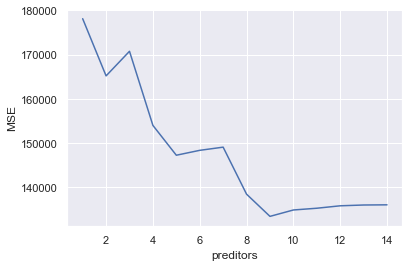

In [61]:
# Using 50% hold out set (validation set)
MSEs= []
for m in best_subsets:
    model = m[1]
    y_hat = model.predict(X_test)
    r =mse(y_hat, y_test)
    MSEs += [r]

results = pd.DataFrame({'preditors': np.arange(1,15),'MSE':MSEs})
display(results)
sns.lineplot(x='preditors', y ='MSE', data= results)

Above we performed best subset selection up to 14 predictors using the training set createad from a 50% hold-out set. We then use the test set to measure the MSE for the selected model in each subset of p predictors. 

We observe the lowest MSE for the model with 9 predictors.

In [62]:
# Which 9 predictors did best subset selection choose based on the TRAINING set?
best_subsets[8][0]

'Salary ~ AtBat + Hits + HmRun + Walks + CAtBat + CRuns + CRBI + CWalks + PutOuts'

In [63]:
# Which 9 predictors does best subset selection choose based on the FULL set?
best_subsets_full = best_subset_rss(hitters.loc[:, 'AtBat':'PutOuts'],hitters['Salary'])
best_subsets_full =[8][0]

Best subset selected: k = 1/14, done
Best subset selected: k = 2/14, done
Best subset selected: k = 3/14, done
Best subset selected: k = 4/14, done
Best subset selected: k = 5/14, done
Best subset selected: k = 6/14, done
Best subset selected: k = 7/14, done
Best subset selected: k = 8/14, done
Best subset selected: k = 9/14, done
Best subset selected: k = 10/14, done
Best subset selected: k = 11/14, done
Best subset selected: k = 12/14, done
Best subset selected: k = 13/14, done
Best subset selected: k = 14/14, done


This time the same model is selected using the full dataset, as is selected using just the training set. This won't always be the case however, so the ISL authors reccomend taking the model that best subset selection chooses using the full dataset.

**Revision note:** My understanind of what the authors seem to be suggesting is:

- fit all possible models on training set
- choose best model in each subset by RSS
- use test MSE to choose best subset, e.g optimal number of predictors *p*
- fit all possible models with optimal value of p predictors on *full* dataset
- choose best model by RSS

This seems odd to me because the model finaly chosen has not been verified on the test set. If the actual predictors are to be chosen on the full set, why not pass this model through validation? Note that this does not mean the model fitted on full dataset is then used in test:

- fit all possible models on full dataset
- choose best combination of predictors in each subset by RSS
- use above choices to fit models on training set
- use test MSE to choose best subset
- model with lowest MSE is chosen

This approach also seems to simplify use of best subset selection with cross-validation:

- fit all possible models on full dataset
- choose best combination of predictors in each subset by RSS
- choose from above predictor subsets using cross validation

In [64]:
def cross_val(fromula, X, y, k):
    # Split dataset into k folds:
    # Note: np.array_split dose not raise exception is folds folds are unequal in size.
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y,k)

    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test = X_folds[f]
        y_test = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        # Fit model
        model = smf.ols(formula=formula, data=pd.concat([X_train, y_train], axis=1)).fit()
        
        # Measure MSE
        y_hat = model.predict(X_test)
        MSEs += [mse[y_hat, y_test]]
    return (MSEs, formula)

In [65]:
# Get best subsets of predictors for full dataset
X = hitters.loc[:, 'AtBat':'PutOuts']
y = hitters['Salary']

best_subsets_full = best_subset_rss(X,y)



Best subset selected: k = 1/14, done
Best subset selected: k = 2/14, done
Best subset selected: k = 3/14, done
Best subset selected: k = 4/14, done
Best subset selected: k = 5/14, done
Best subset selected: k = 6/14, done
Best subset selected: k = 7/14, done
Best subset selected: k = 8/14, done
Best subset selected: k = 9/14, done
Best subset selected: k = 10/14, done
Best subset selected: k = 11/14, done
Best subset selected: k = 12/14, done
Best subset selected: k = 13/14, done
Best subset selected: k = 14/14, done


In [66]:
# Perform cross validation for each subset of predictor
restuls = []

for sub in best_subsets_full:
    results += [cross_val(sub[0],X,y,10)]

results_a_df = pd.DataFrame({'preditors': list(np.arange(1,15)),
                                                    'MSE_mean':[np.mean(i[0]) for i in results],
                                                    'MSE_folds': [i[0] for i in results],
                                                    'Model': [i[1] for i in results]}
)
display(results_a_df)
sns.lineplot(x='preditors',y='MSE_mean',data=results_a_df)


NameError: name 'formula' is not defined

In [90]:
# Error, test later

## 6.5.2 Ridge Regression and the Lasso
[JWarmenhoven version](https://nbviewer.jupyter.org/github/JWarmenhoven/ISLR-python/blob/master/Notebooks/Chapter%206.ipynb#6.6.1-Ridge-Regression)

In [93]:

# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glmnet as gln

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('seaborn-white')

In [97]:
df = pd.read_csv('../data/Hitters.csv', index_col=0).dropna()
df.index.name ='Player'
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 315 to 631
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Hits       263 non-null    int64  
 1   HmRun      263 non-null    int64  
 2   Runs       263 non-null    int64  
 3   RBI        263 non-null    int64  
 4   Walks      263 non-null    int64  
 5   Years      263 non-null    int64  
 6   CAtBat     263 non-null    int64  
 7   CHits      263 non-null    int64  
 8   CHmRun     263 non-null    int64  
 9   CRuns      263 non-null    int64  
 10  CRBI       263 non-null    int64  
 11  CWalks     263 non-null    int64  
 12  League     263 non-null    object 
 13  Division   263 non-null    object 
 14  PutOuts    263 non-null    int64  
 15  Assists    263 non-null    int64  
 16  Errors     263 non-null    int64  
 17  Salary     263 non-null    float64
 18  NewLeague  263 non-null    object 
dtypes: float64(1), int64(15), object(3)
memory usage

,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,
315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [100]:
dummies = pd.get_dummies(df[['League', 'Division','NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 315 to 631
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   League_A     263 non-null    uint8
 1   League_N     263 non-null    uint8
 2   Division_E   263 non-null    uint8
 3   Division_W   263 non-null    uint8
 4   NewLeague_A  263 non-null    uint8
 5   NewLeague_N  263 non-null    uint8
dtypes: uint8(6)
memory usage: 3.6 KB
        League_A  League_N  Division_E  Division_W  NewLeague_A  NewLeague_N
Player                                                                      
315            0         1           0           1            0            1
479            1         0           0           1            1            0
496            0         1           1           0            0            1
321            0         1           1           0            0            1
594            1         0           0           1            1           

In [102]:
y = df.Salary
# Drop the column with the independent variable (Salary),
#  and columns for which we created dummy variables. 
X_ = df.drop(['Salary','League', 'Division','NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()
X.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 315 to 631
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Hits         263 non-null    float64
 1   HmRun        263 non-null    float64
 2   Runs         263 non-null    float64
 3   RBI          263 non-null    float64
 4   Walks        263 non-null    float64
 5   Years        263 non-null    float64
 6   CAtBat       263 non-null    float64
 7   CHits        263 non-null    float64
 8   CHmRun       263 non-null    float64
 9   CRuns        263 non-null    float64
 10  CRBI         263 non-null    float64
 11  CWalks       263 non-null    float64
 12  PutOuts      263 non-null    float64
 13  Assists      263 non-null    float64
 14  Errors       263 non-null    float64
 15  League_N     263 non-null    uint8  
 16  Division_W   263 non-null    uint8  
 17  NewLeague_N  263 non-null    uint8  
dtypes: float64(15), uint8(3)
memory usage: 33.6 KB


,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
Player,,,,,,,,,,,,,,,,,,
315,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
479,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
496,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
321,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1
594,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1,0


In [103]:
# Downloaded the exact same training/test sets used in the book.
X_train = pd.read_csv('../data/Hitters_X_train.csv', index_col = 0)
y_train = pd.read_csv('../data/Hitters_y_train.csv', index_col = 0)
X_test = pd.read_csv('../data/Hitters_X_test.csv', index_col =0)
y_test = pd.read_csv('../data/Hitters_y_test.csv', index_col =0)

###  6.6.1 Ridge Regression
Scikit-learn

The glmnet algorithms in R optimize the objective function using cyclical coordinate descent, while scikit-learn Ridge regression uses linear least squares with L2 regularization. They are rather different implementations, but the general principles are the same.

The glmnet() function in R optimizes:

The function supports L1 and L2 regularization. For just Ridge regression we need to use α=0. This reduces the above cost function to

$$
\frac{1}{N}||Xβ - y||_2^2 + λ((1 - α)||β||_2^2 + α||β||_1)
$$
The sklearn Ridge() function optimizes:
$$
||X\beta - y||^2_2 + \alpha ||\beta||^2_2
$$
which is equivalent to optimizing
$$
\frac{1}{N}||X\beta - y||^2_2 + \frac{\alpha}{N} ||\beta||^2_2
$$

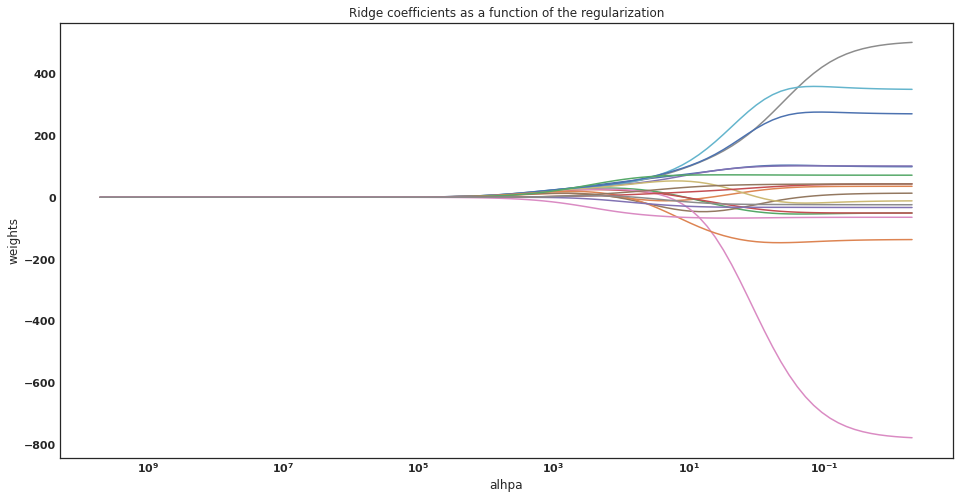

In [132]:
alphas = 10 ** np.linspace(10,-2,100) * 0.5

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X),y)
    coefs.append(ridge.coef_)

plt.figure(figsize=(16,8))
ax = plt.gca()
ax.plot(alphas,coefs)
ax.set_xscale('log')
ax.set(xlabel='alhpa',ylabel='weights',
            xlim =ax.get_xlim()[:: -1],# reverse axis
            title = 'Ridge coefficients as a function of the regularization')
plt.show()